In [1]:
import sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib notebook

60/94/120 Ah, 60Ah -> 22kWh
optional engine -> REx

In [2]:
df = pd.read_csv('data/AS24_BMWi3.csv', index_col=0)

In [25]:
df.head()

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price,kW,age
0,BMW i3,Garanzia batterie e motore 12 mesi,['Brokar - Professional Car Brokerage - Interm...,109954.0,2013-08-01,75 kW (102 CV),Usato,3.0,Automatico,Elettrica,12900,75,8.252052
60,BMW i3,top ful ful optional,NaN,150000.0,2013-11-01,75 kW (102 CV),Usato,NaN,None,Elettrica,20000,75,8.000164
22,BMW i3,cerchi 19 pelle navi grande tetto apribile,NaN,65300.0,2013-12-01,75 kW (102 CV),Usato,NaN,None,Elettrica,14900,75,7.918027
33,BMW i3,NaN,NaN,68000.0,2014-02-01,75 kW (102 CV),Usato,NaN,Automatico,Elettrica,16650,75,7.748277
28,BMW i3,NaN,NaN,50000.0,2014-04-01,75 kW (102 CV),Usato,2.0,None,Elettrica,16000,75,7.586740


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 246 entries, 0 to 245
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   model       246 non-null    object 
 1   version     236 non-null    object 
 2   equipments  17 non-null     object 
 3   mileage     202 non-null    float64
 4   mmyy        246 non-null    object 
 5   power       246 non-null    object 
 6   use_type    246 non-null    object 
 7   n_owners    95 non-null     float64
 8   gear        246 non-null    object 
 9   fuel_type   246 non-null    object 
 10  price       246 non-null    int64  
dtypes: float64(2), int64(1), object(8)
memory usage: 23.1+ KB


In [31]:
#all the cars having null mileage are new
df[df.mileage.isna()]['mmyy'].unique()
#set mileage = 0
df.loc[df.mileage.isna(),'mileage'] = 0

In [6]:
#power
df.power.value_counts()

75 kW (102 CV)     150
125 kW (170 CV)     77
135 kW (184 CV)     18
1 kW (1 CV)          1
Name: power, dtype: int64

One has 1kW, which must be wrong

In [33]:
df['kW'] = df['power'].apply(lambda x: int(x.split()[0]))
df[df.kW==1]

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price,kW,age
192,BMW i3,(I01) 120 Ah,NaN,119.0,2019-08-01,1 kW (1 CV),KM0,NaN,Automatico,Elettrica,35900,1,2.253297


In [34]:
#no info found. let's assume it has the more frequent power (75 kW)
df.loc[192, 'kW'] = 75

In [35]:
#fuel type columns
df.fuel_type.value_counts()

Elettrica            225
Elettrica/Benzina     21
Name: fuel_type, dtype: int64

In [38]:
# 'Elettrica/Benzina' means it has an extender range engine. But actually all of these cars have it.
#boole = df.fuel_type == 'Elettrica/Benzina'
#df[boole]

In [39]:
df.use_type.unique()

array(['Usato', 'Dimostrativo', 'KM0', 'Aziendale', 'Nuovo'], dtype=object)

In [40]:
#all these cars have automatic gear
df.gear.unique()

array(['Automatico', None, 'Manuale'], dtype=object)

In [42]:
df['mmyy'] = df['mmyy'].apply(pd.to_datetime)
df = df.sort_values(by=['mmyy'], ascending=True)

In [43]:
now = pd.to_datetime('11/2021')

In [44]:
df['age']  = (now - df.mmyy) / np.timedelta64(1, 'Y')

<IPython.core.display.Javascript object>


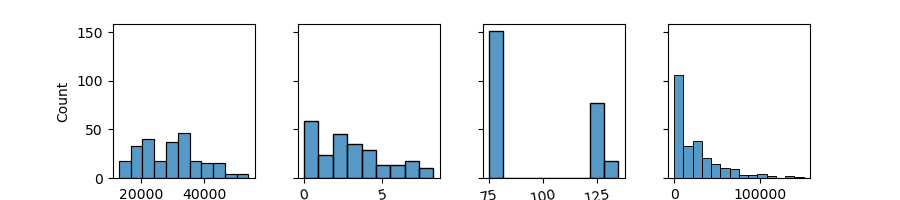

In [50]:
f, ax = plt.subplots(figsize=(9, 2), nrows=1, ncols=4, sharey=True, gridspec_kw={'hspace':0.4, 'wspace':0.3})
for i,var in enumerate(['price', 'age', 'kW','mileage']):
    g = sns.histplot(x=var, data=df, ax=ax[i])
    if i in [1,2]:
        ax[i].tick_params(axis='x', rotation=10)

<IPython.core.display.Javascript object>


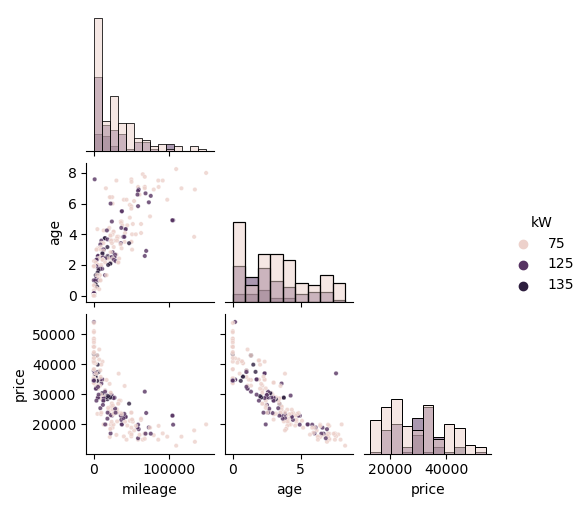

In [52]:
feat = ['mileage','kW','age','price']
g = sns.pairplot(df[feat], hue="kW", height=1.7, diag_kind="hist", corner=True, plot_kws={"s": 10, 'alpha':0.8})

In [71]:
#there are few outliers
bool_to_drop1 = (df.mileage > 65000) & (df.kW > 100) & (df.price>19500)
bool_to_drop2 = (df.price > 30000) & (df.age > 6.8)
idx_to_drop = df.index[(bool_to_drop1 | bool_to_drop2)]
df.drop(index=idx_to_drop, inplace=True)

In [92]:
mileage_sorted = df.mileage.sort_values(ascending=False)

In [214]:
bins = np.array([0, 100, 20000, 40000, 60000, 80000, 180000])
inds = np.digitize(df.mileage, bins)
list_n_bins = np.unique(inds)
list_median = []
for i in list_n_bins:
    boole = (inds==i)
    list_median.append(df.price[boole].median())

In [215]:
list_median.append(list_median[-1])
array_median = np.array(list_median)
inds

array([6, 6, 5, 5, 4, 6, 6, 3, 4, 5, 6, 4, 5, 5, 2, 6, 4, 6, 6, 4, 5, 5,
       4, 5, 3, 3, 3, 4, 6, 4, 4, 5, 3, 3, 4, 4, 4, 4, 3, 3, 5, 4, 3, 3,
       3, 3, 4, 5, 3, 4, 3, 3, 4, 2, 4, 2, 2, 2, 3, 3, 5, 4, 4, 3, 4, 3,
       3, 3, 3, 3, 3, 3, 6, 4, 3, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 3, 3, 4,
       4, 4, 2, 2, 4, 3, 3, 3, 2, 2, 2, 3, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2,
       2, 3, 3, 2, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 3, 3, 3, 3, 2, 2,
       2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 3, 3, 3, 2, 3, 3, 3, 2, 2, 2, 2, 2,
       1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
       1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [196]:
df.mileage

0      109954.0
60     150000.0
22      65300.0
33      68000.0
28      50000.0
         ...   
232         0.0
231         0.0
228         0.0
229         0.0
208         1.0
Name: mileage, Length: 240, dtype: float64

<IPython.core.display.Javascript object>


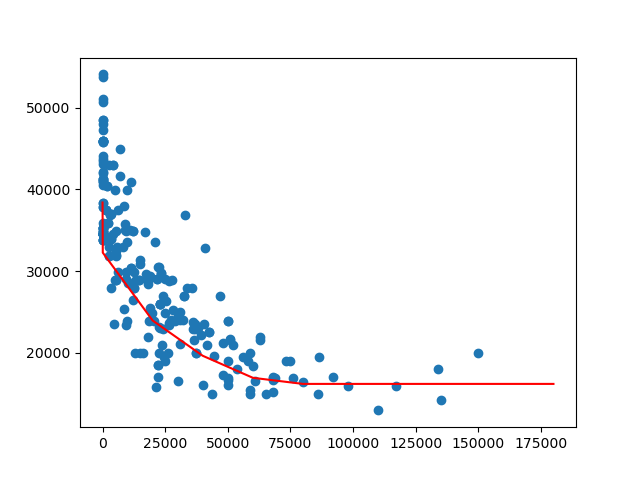

In [216]:
fig, ax = plt.subplots()
plt.scatter(df.mileage, df.price)
plt.plot(bins, array_median, c='red')


In [262]:
df['inds'] = inds
df['price_d1'] = df.inds.apply(lambda x: list_median[x])
#fig_of_merit = (1 - df.age/df.age.max()) + (1. - df.mileage/df.mileage.max()) + (1. - df.price/df.price.max()) + 3*(1. - df.price_d1/df.price_d1.max())
df['fig_of_merit'] = (1. - df.mileage/df.mileage.max()) + (1. - df.price/df.price.max()) + (1. - df.price_d1/df.price_d1.max())


<IPython.core.display.Javascript object>


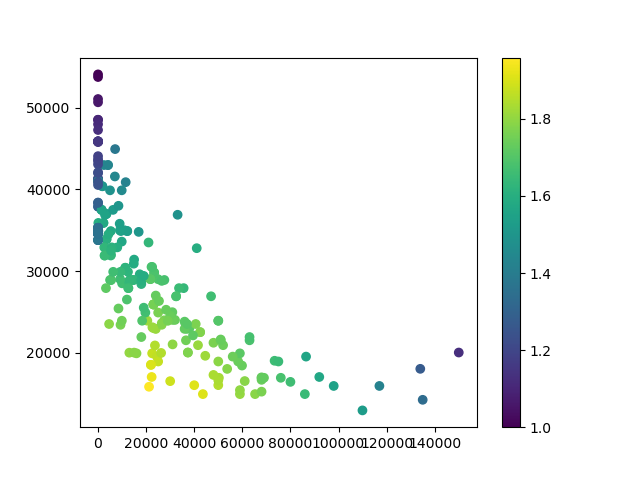

In [263]:
fig, ax = plt.subplots()
plt.scatter(df.mileage, df.price, c=df.fig_of_merit, cmap='viridis')
plt.colorbar()

In [265]:
df.sort_values(by='fig_of_merit', ascending=False)

,model,version,equipments,mileage,mmyy,power,use_type,n_owners,gear,fuel_type,price,kW,age,inds,price_d1,fig_of_merit
3,BMW i3,i3 *KM 21.000,"['Sistema di navigazione, Airbag laterali, Con...",21215.0,2015-06-01,75 kW (102 CV),Usato,NaN,Automatico,Elettrica,15800,75,6.420392,3,19600.0,1.958861
37,BMW i3,FULL ELECTRIC 170CV IVA 22% DEDUCIBILE COMPRESA,NaN,22300.0,2015-11-01,125 kW (170 CV),Usato,1.0,Automatico,Elettrica,17000,125,6.001492,3,19600.0,1.929455
27,BMW i3,- EcoBonus 2021 - 60 Ah,NaN,40000.0,2015-08-01,75 kW (102 CV),Usato,NaN,Automatico,Elettrica,15990,75,6.253380,4,16900.0,1.913840
21,BMW i3,GaranziaBMW-EsenteBollo5Anni-Legge104-Ecobonus,NaN,43600.0,2015-08-01,75 kW (102 CV),Usato,1.0,Automatico,Elettrica,14900,75,6.253380,4,16900.0,1.909980
42,BMW i3,60 Ah 102 CV Aut.,NaN,22000.0,2017-12-01,75 kW (102 CV),Usato,2.0,Automatico,Elettrica,18490,75,3.917945,3,19600.0,1.903924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,BMW i3,s 120 Ah Aut. LISTINO € 48.553,NaN,0.0,2021-11-01,75 kW (102 CV),Nuovo,NaN,Automatico,Elettrica,48553,75,0.000000,1,32249.5,1.102864
242,BMW i3,120Ah Advantage,NaN,0.0,2021-11-01,75 kW (102 CV),Nuovo,NaN,Automatico,Elettrica,50700,75,0.000000,1,32249.5,1.063193
243,BMW i3,s 120Ah Advantage,NaN,0.0,2021-11-01,75 kW (102 CV),Nuovo,NaN,Automatico,Elettrica,51100,75,0.000000,1,32249.5,1.055802
244,BMW i3,s 120Ah Advantage,NaN,0.0,2021-11-01,75 kW (102 CV),Nuovo,NaN,Automatico,Elettrica,53800,75,0.000000,1,32249.5,1.005913
